In [3]:
import pandas as pd
import seaborn as sns
import json
import requests
import numpy as np

In [5]:
r = requests.get('http://localhost:5000/v1/stats/data/full')
df = pd.read_json(json.dumps(r.json()))

## Exploring the data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103658 entries, 0 to 103657
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   age_6              19184 non-null   float64
 1   cma                103658 non-null  int64  
 2   cma_name           103658 non-null  object 
 3   cowmain            67062 non-null   float64
 4   cowmain_name       103658 non-null  object 
 5   educ               103658 non-null  int64  
 6   full_naics_21      103658 non-null  object 
 7   immig              103658 non-null  object 
 8   index              103658 non-null  int64  
 9   is_student         76893 non-null   float64
 10  lfsstat            103658 non-null  int64  
 11  naics_21           103658 non-null  object 
 12  prov               103658 non-null  int64  
 13  prov_name          103658 non-null  object 
 14  schooln            76893 non-null   float64
 15  sex                103658 non-null  object 
 16  st

### Dataset first look
The dataframe has a total of 18 different columns. Those columns only use the following types: `[object, int64 and float64]`. We can determine that the boolean values, for instance, `is_student` has been encoded to a float when importing the data in mysql.

### Null and Non-null values
A few columns with 103658 non-null values have null values at all since there is a total of 103658 entries.

It is interesting to note that the new columns we have created in the cleaning process have no non-null values, since the mapping from the source column includes setting a non-null value even when the source value in `NaN.

For instance, if the original value for `cowmain` is `NaN`, the corresponding `cowmain_name` would be `'Not applicable'`

### Other observations
We also note that the source data has some columns such as `age_6` which is missing source information since we would expect any person to have an age. This would probably be attributable to the inability to acquire this data during the data collection phase, when creating the dataset.

### Let's fix the boolean conversion issue for is_student

In [7]:
df['is_student'] = df['is_student'].map(lambda x: bool(x))

In [8]:
df['is_student'].to_frame().query('is_student != True').count()


is_student    1586
dtype: int64

In [9]:
df['is_student'].to_frame().query('is_student == True').count()


is_student    102072
dtype: int64

This leaves the question: is almost everyone a student? Was there an issue? Why such discrepancies between students and non-students?

## Gender distribution

### Distribution of gender per province

In [279]:
genderPerProv = df[['sex', 'prov_name']].groupby('prov_name').value_counts()
genderPerProv

prov_name  sex
AB         F       4030
           M       3945
BC         F       6804
           M       6191
MB         F       4357
           M       4147
ND         F       2854
           M       2612
NL         F       2107
           M       1963
NS         F       2776
           M       2485
ON         F      16515
           M      15515
PE         F       1167
           M       1085
QC         F       9940
           M       9476
SK         F       2941
           M       2748
dtype: int64

### Distribution of gender in Quebec

In [289]:
genderInQc = df[df['prov_name'] == "QC"]['sex'] #.value_counts()
distGenderInQc = genderInQc.value_counts()
distGenderInQc

F    9940
M    9476
Name: sex, dtype: int64

## What is the labour force status, per province, for all the workers?

In [12]:
# 14,1,2017,, lfsstat    ,Labour force status,Situation d'activit�,,,,,,,,,
# ,,,,,,,,,,,1,"Employed, at work","Personnes occup�es, au travail",,
# ,,,,,,,,,,,2,"Employed, absent from work","Personnes occup�es, absentes du travail",,
# ,,,,,,,,,,,3,Unemployed,Ch�meurs,,
# ,,,,,,,,,,,4,Not in labour force,Inactifs,,

# We exclude lfsstat == 4 since this means the person is not in workforce, therefore not a worker
df.query('lfsstat != 4')[['lfsstat', 'prov_name']].groupby('prov_name').value_counts()

prov_name  lfsstat
AB         1           4603
           3            360
           2            351
BC         1           7066
           2            540
           3            386
MB         1           4782
           2            363
           3            236
ND         1           2581
           3            258
           2            249
NL         1           1863
           3            262
           2            193
NS         1           2513
           2            225
           3            214
ON         1          17136
           2           1392
           3           1051
PE         1           1135
           3            149
           2             96
QC         1          10369
           2            945
           3            540
SK         1           3228
           2            313
           3            174
dtype: int64

## What is the student status of students per age group?
### For example, you would be able to say “x% of people between 25 to 26 are students.

In [28]:
# Grouping student status per age group
students_per_age_group_df = df[['age_6', 'is_student']].groupby('age_6').value_counts().to_frame()

In [66]:
# Grouping student status for people between 25 and 26
# age_6 refers to "Age in 2 and 3 year groups, 15 to 29". age_6 value 5 means 25 to 26 years
studentsCount = students_per_age_group_df.query('age_6 == 5 and is_student == True').values[0][0]
totalRespondantsForAgeGroup = students_per_age_group_df.query('age_6 == 5').sum(0).values[0]
studentPercentage = studentsCount / totalRespondantsForAgeGroup * 100
print(studentPercentage)

95.85215605749487


### “x% of people between 25 to 26 are students per province

In [218]:
totalRespondantsForAgeGroupPerProvince = df[['age_6', 'prov_name']].query('age_6 == 5').groupby('prov_name').count()
totalRespondantsForAgeGroupPerProvince['total_respondants'] = totalRespondantsForAgeGroupPerProvince['age_6']


,total_respondants
prov_name,
AB,181
BC,319
MB,232
ND,106
NL,78
NS,130
ON,768
PE,49
QC,416


In [224]:
numberStudentsPerProv = df[['age_6', 'is_student', 'prov_name']].query('(age_6 == 5.0) and (is_student == True)').groupby('prov_name').count().drop('age_6', axis=1)


In [247]:

percentages = totalRespondantsForAgeGroupPerProvince.drop('age_6', axis=1).merge(
    numberStudentsPerProv,
    on='prov_name'
)
percentages['student_percentage'] = (percentages['is_student'] / percentages['total_respondants']) * 100
percentages


,total_respondants,is_student,student_percentage
prov_name,,,
AB,181,178,98.342541
BC,319,306,95.924765
MB,232,214,92.241379
ND,106,102,96.226415
NL,78,75,96.153846
NS,130,129,99.230769
ON,768,733,95.442708
PE,49,48,97.959184
QC,416,394,94.711538


### Display the student percentages per province visually

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

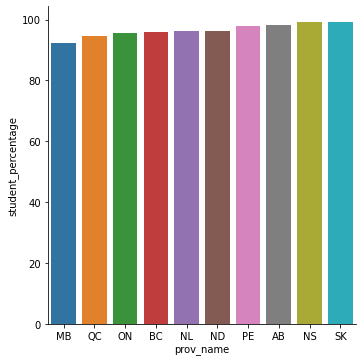

In [293]:
plot = sns.catplot(data=percentages, x=percentages.index, y=percentages.student_percentage, kind="bar", order=percentages.sort_values('student_percentage').index)


<AxesSubplot:title={'center':'Gender Distribution in Quebec'}, ylabel='sex'>

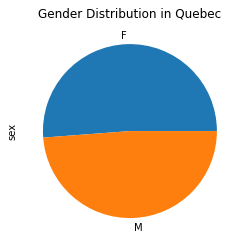

In [292]:
distGenderInQc.plot(kind="pie", title="Gender Distribution in Quebec")

### Note

I hope this fulfills the expectations. My partner caught COVID this week and I have been camping in the lounge. On top of this, we were releasing an overdue reporting solution for clients this week, so I haven't had as much time and concentration to dedicate to this project. Thanks for your understanding and for the semester.